# Yelp event attendance count prediction

Yelp is holding various kinds interesting events which includes food, tourism and festivals etc. Users can see information of these events by browsing Yelp's official website. By clicking "I'm in" or "Sounds Cool", users show their interest in that event. However, they may actually participate in for many reasons. In this project, we will use historical event related information as our data source, building models to prediction actual attendance count of future events. An accurate prediction will definitely leverage business value to bussinesses. They can do proper amout of prepartion if they know how many people will actually attend before the event. This can avoid surplus preparation which may cause extra cost and also not enough preparation which may cause customer loss.

## Project Content

We will cover following steps in this project:
* [Loading data and processing](#Loading-data-and-processing)
* [Data visualization and exploration](#Data-visualization-and-exploration)
* [Data preparation](#Data-preparation)
* [Feature engineering](#Feature-engineering)
* [Data modeling](#Data-modeling)
* [Conclusion](#Conclusion)
* [Lessons learned](#Lessons learned)

## Loading data and processing

#### We call Yelp Fusion API to get data we need. It's Event Search in Event Endpoints. There are 29 features of each event includes and the meaning of each features are also shown here.
1. attending_count - Number of Yelp users actually attended this event; 2. interested_count - Number of Yelp users interested in attending this event; 3. category - The category alias of this event; 4. cost - Cost of attending this event; 5. cost_max - Maximum cost of this event; 6. description - Event description; 7. event_site_url - Yelp page of this event; 8. id - Event id; 9. image_url - Yelp image URL of this event; 10. is_canceled - Whether this event is canceled; 11. is_free - Whether this event is free; 12. is_official - Whether this event is created by a Yelp community manager; 13. latitude - Latitude of this event; 14. longitude - Longitude of this event; 15. name - Name of this event; 16. tickets_url - URL to buy tickets for this event; 17. time_end - Time this event ends; 18. time_start - Time this event starts; 19. location - The location of this event,including address, city, state, zipcode and country; 20. location.address1 - Street address of this event; 21. location.address2 - Street address of this event, continued; 22. location.address3 - Street address of this event, continued; 23. location.city - City of this event; 24. location.zip_code - Zip code of this event; 25. location.country - Country the event is taking place in; 26. location.state - State of this event; 27. location.display_address - Array of strings that if organized vertically give an address that is in the standard address format for the event's country; 28. location.cross_streets - Cross streets of this event; 29. business_id - Business ID of this event.

Firstly, read_api_key function reads in api key we stored in file.

In [1]:
import io, time, json
import requests
import pandas as pd

In [2]:
def read_api_key(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    # feel free to modify this function if you are storing the API Key differently
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')

In [3]:
api_key = read_api_key('api_key.txt')

This function returns all features related 50 yelp events. Yelp API sets the limitation that we can only fetch data of 50 events each time calling the API. We set limit to 50 to reach the maximum limit. However, we need large amount of data to do analysis to we need to call API many times. By setting offset, we can avoid getting duplicate data each time calling API. In addition, we pass city name value to location field to get information in a particular city. 

In [4]:
def yelp_search(api_key, offset, cityName):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of dicts representing each business
    """
    
    # Write solution here    
    headers = {
        'Authorization': 'Bearer %s' % api_key
    } 
    
    params = {
        'limit': 50,
        'offset': offset,
        'location': cityName
    }
    response = requests.get('https://api.yelp.com/v3/events', headers=headers, params=params)
    result = response.json()

    return result["events"]

We gather data of major cities in California. Calling yelp_search function several times to get data of each city and write the result out to the csv file named yelpresult.csv. 

In [5]:
# city names in CA
cityNameInCA = ['Los Angeles', 'San Francisco', 'San Diego', 'Sacramento', 'San Jose', 'Oakland', 'Long Beach', \
                  'Anaheim', 'Irvine', 'Pasadena', 'Santa Monica', 'Fremont', 'Santa Ana', 'Beverly Hills', \
                  'Newport Beach', 'Santa Clara', 'Burbank', 'Mountain View', 'Fresno', 'Bakersfield', 'Riverside', \
                  'Stockton', 'Santa Barbara', 'Palm Springs', 'Monterey', 'Modesto', 'Santa Cruz', 'San Bernardino']

resultDataFrame = pd.DataFrame()
# multiple cities
for cityName in cityNameInCA:    
    for offset in range(1,902,50):
        # call yelp_search serveral times
        eventInformation = yelp_search(api_key, offset, cityName)
        if(len(eventInformation) > 0):
            theResultDataFrame = pd.DataFrame()
            eventKeys = eventInformation[0].keys()
            # go through all event keys
            for eventKey in eventKeys:
                if eventKey != 'location':
                    eventKeyList = list(map(lambda x: x[eventKey], eventInformation))
                    # append to dataframe
                    se = pd.Series(eventKeyList)
                    theResultDataFrame[eventKey] = se.values        
                if eventKey == 'location':
                    locationInformation = list(map(lambda x: x['location'], eventInformation))
                    locationKeys = eventInformation[0]['location'].keys()
                    for locationKey in locationKeys:
                        locationKeyList = list(map(lambda x: x[locationKey], locationInformation))
                        se = pd.Series(locationKeyList)
                        theResultDataFrame[locationKey] = se.values 
            theResultDataFrame = theResultDataFrame.loc[theResultDataFrame['state'] == 'CA'] 
            resultDataFrame = resultDataFrame.append(theResultDataFrame)

# write out to yelpresult.csv
resultDataFrame.to_csv('yelpresult.csv', index=False)

In [6]:
len(resultDataFrame)

19796

We gathered 19796 data in total. After we have all data in our hand, we cleaned and filtered data in the following way. 

We removed events with attending count equals to 1

In [10]:
# read in 
cleanedDataframe = pd.read_csv('yelpresult.csv',encoding = "ISO-8859-1")
#cleanedDataframe = cleanedDataframe.encode('utf-8').strip()
# remove attending count with 1
cleanedDataframe = cleanedDataframe[(cleanedDataframe.attending_count != 1)]

We also retained columns we need. Features for attendance count prediction: interested_count, is_free, city, latitude, category, longitude, is_official, time_end, id, time_start, attending_count. And then we droped columns with NAN. 

In [11]:
# get features
cleanedDataframe = cleanedDataframe[['interested_count', 'is_free', 'city', 'latitude', 'category', 'longitude', \
                                       'is_official', 'time_end', 'id', 'time_start', 'attending_count']]
cleanedDataframe = cleanedDataframe.dropna() 
cleanedDataframe.to_csv('yelpResultCleaned.csv', index=False)

In [13]:
len(cleanedDataframe)

8854

The cleaned data set has 11685 data. Now we are ready to use this data set to do data visualization and model building.

## Data visualization and exploration

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
from folium.plugins import HeatMap

%matplotlib inline

In this part, we will use some features to do data visualization so that we can know about the features that may affect attending count of Yelp events. We will use Seaborn package and Gmaps to plot some figures and do data exploration. There's several columns that may have relationships with attending count.

In [15]:
df = cleanedDataframe
df.head()

,interested_count,is_free,city,latitude,category,longitude,is_official,time_end,id,time_start,attending_count
0,193,True,Los Angeles,34.063596,kids-family,-118.292773,False,2009-08-09 03:00,los-angeles-korean-bbq-festival-and-cook-off,2009-08-08 19:00,298
1,191,False,Los Angeles,34.052187,festivals-fairs,-118.243425,False,2010-02-14 01:00,los-angeles-la-street-food-fest,2010-02-13 19:00,396
5,63,True,Los Angeles,34.052187,festivals-fairs,-118.243425,False,2011-12-26 17:30,los-angeles-take-the-yelp-shops-local-pledge,2011-11-04 15:30,233
6,118,True,Los Angeles,34.052187,nightlife,-118.243425,False,2012-03-05 07:00,los-angeles-yelp-drinks-week-imbibe-for-up-to-...,2012-02-27 23:00,266
7,181,True,Los Angeles,34.052187,festivals-fairs,-118.243425,False,2012-09-01 01:30,los-angeles-yelps-100-days-of-summer,2012-07-08 00:30,654


Firstly, we will set the style of the plot background. We will set it as "white".

In [16]:
sns.set_style("white")

For analyzing the attending count, we have plotted the distribution of attending count of each event.

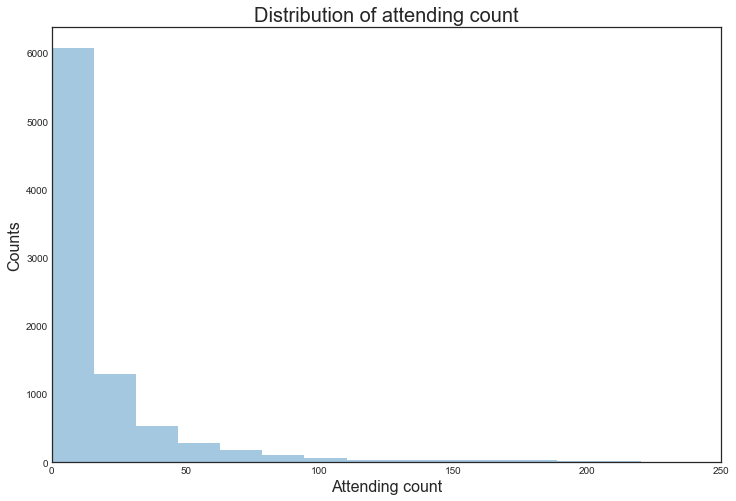

In [17]:
# set the size of the figure to fit the screen
plt.rcParams['figure.figsize'] = 12,8
# plot distribution of attending count
attending_count = df['attending_count']
ax = sns.distplot(attending_count,bins= 100, kde=False)

ax.set_xlabel(xlabel='Attending count', fontsize=16)
ax.set_ylabel(ylabel='Counts', fontsize=16)
ax.set_title(label='Distribution of attending count', fontsize=20)
plt.xlim(0,250)
plt.show()

From the figure above, we can see that most of the attending counts are from 0 to 50, which is almost 80% of the number of attending counts. It will be likely due to the duration of the event, or location, or categories.

Next, we will see the distribution of categories.

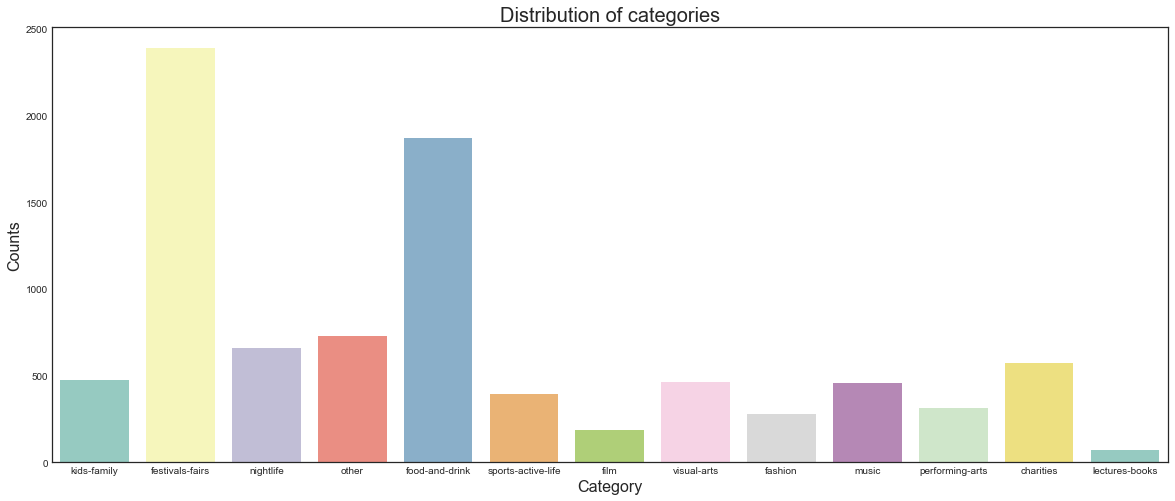

In [18]:
# plot distribution of categories
plt.rcParams['figure.figsize'] = 20,8

category = df['category']
ax = sns.countplot(category, palette="Set3")

ax.set_xlabel(xlabel='Category', fontsize=16)
ax.set_ylabel(ylabel='Counts', fontsize=16)
ax.set_title(label='Distribution of categories', fontsize=20)
plt.show()

From the figure above, festivals-fairs, food-and-drink, nightlife are top 3 of the categories most events will hold. Since these kind of events are not strictly restricted for certain area like sports or films, it is likely that there will be more attending count for these categories.

Then, since many of the costs for events are missing, we will just explore the distribution of if the event is free or not. And we can see from figure below, there's more free events than non-free events.

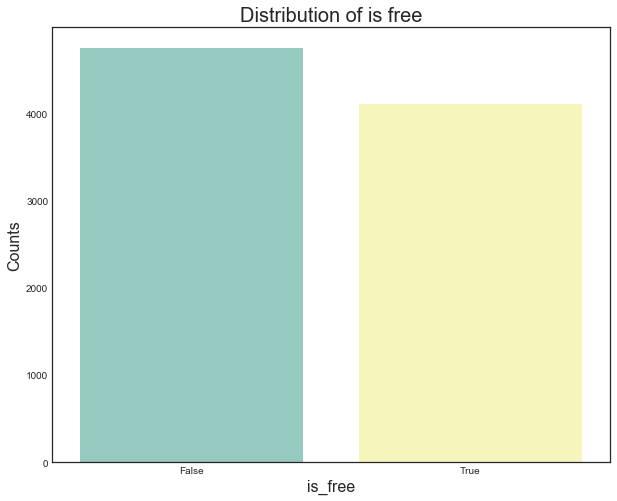

In [19]:
# plot distribution of categories
plt.rcParams['figure.figsize'] = 10,8
is_free = df['is_free']
ax = sns.countplot(is_free, palette="Set3")

ax.set_xlabel(xlabel='is_free', fontsize=16)
ax.set_ylabel(ylabel='Counts', fontsize=16)
ax.set_title(label='Distribution of is free', fontsize=20)
plt.show()

Another feature we think might be useful is cities. So, we plotted the distribution of cities of each event.

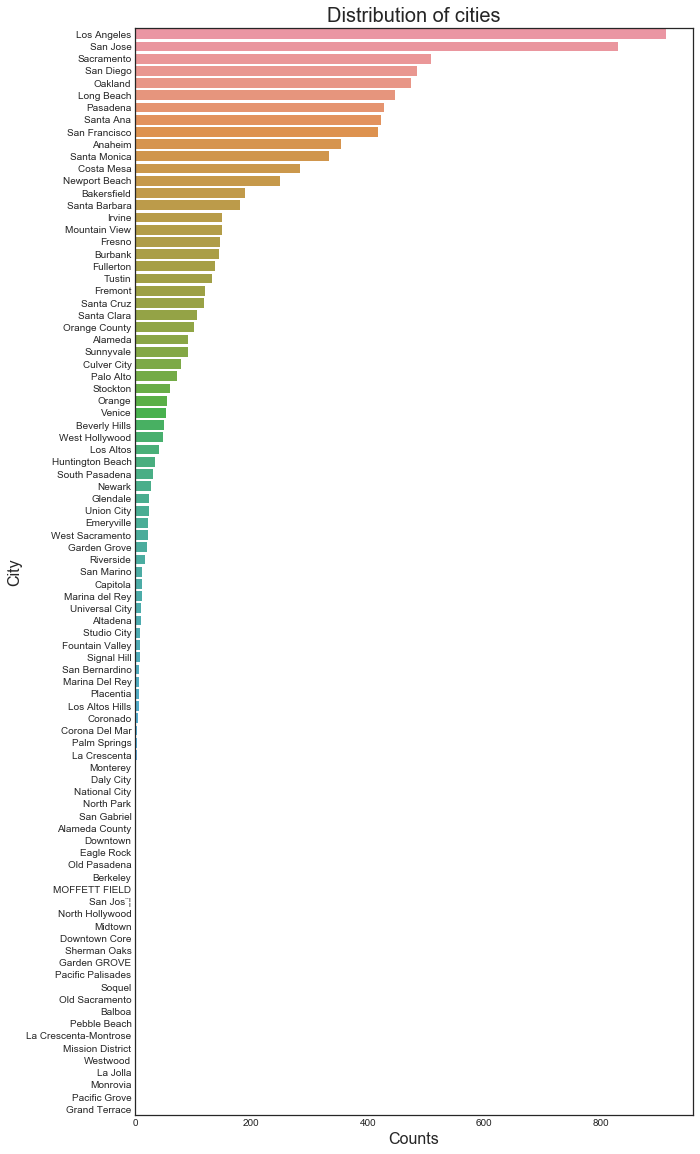

In [20]:
# plot distribution of cities
plt.rcParams['figure.figsize'] = 10,20
city = df['city']
ax = sns.countplot(y=city, order= city.value_counts().index, orient='h')

ax.set_xlabel(xlabel='Counts', fontsize=16)
ax.set_ylabel(ylabel='City', fontsize=16)
ax.set_title(label='Distribution of cities', fontsize=20)
plt.show()

Los Angeles, San Jose, Long Beach are top 3 of holding events. Since these cities are relatively big cities in California, it is reasonable that there's more businesses in these cities, and so there will be more events held.

For analyzing attending count, the insterested count for each event is really helpful. And from the figure below, the insterested count shares same shape of distribution of attending count. And most of the count are aggregated from 0 to 50.

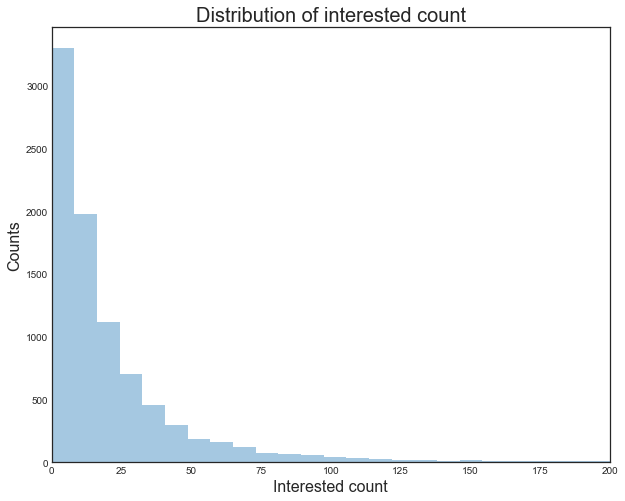

In [21]:
# plot distribution of interested count
plt.rcParams['figure.figsize'] = 10,8
interested_count = df['interested_count']
ax = sns.distplot(interested_count,bins=100, kde=False)

ax.set_xlabel(xlabel='Interested count', fontsize=16)
ax.set_ylabel(ylabel='Counts', fontsize=16)
ax.set_title(label='Distribution of interested count', fontsize=20)
plt.xlim(0,200)
plt.show()

Though interested count of an event may not indicate that the attending count of the event in real world. We try to see the actual relationship between attending count and interested count.

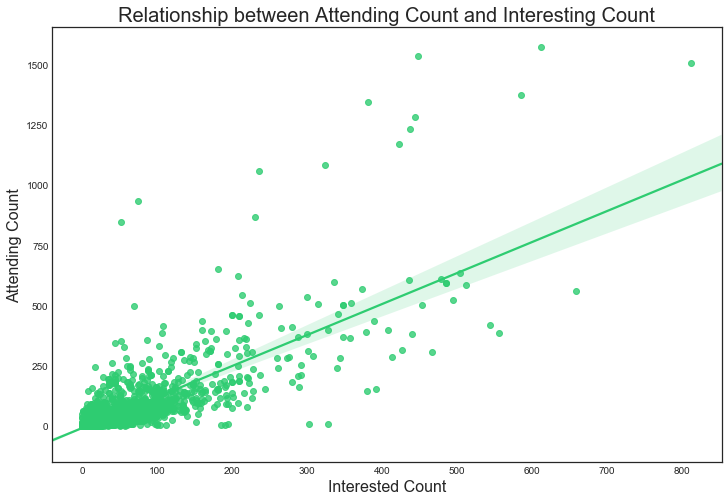

In [22]:
plt.rcParams['figure.figsize'] = 12,8
ax = sns.regplot(x="interested_count", y="attending_count", fit_reg=True, data =df, color="#2ecc71")
ax.set_xlabel(xlabel='Interested Count', fontsize=16)
ax.set_ylabel(ylabel='Attending Count', fontsize=16)
ax.set_title(label='Relationship between Attending Count and Interesting Count', fontsize=20)
plt.show()

However, from the figure above, it seems that the relationship between these two are likely proportional.

Then we plotted another pointplot of the relationship between attending count and intersted count.

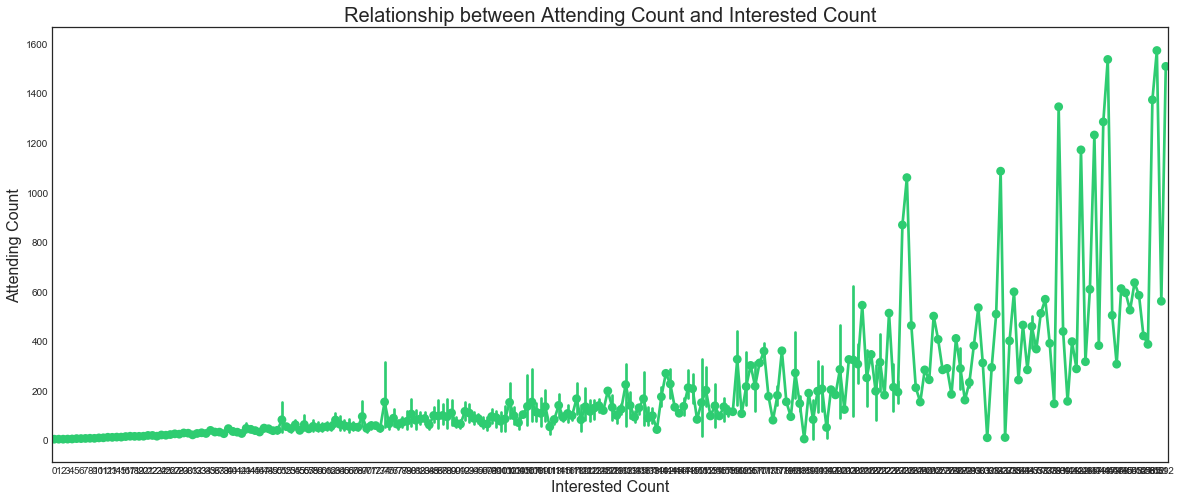

In [23]:
plt.rcParams['figure.figsize'] = 20,8

ax = sns.pointplot(x=df['interested_count'], 
                   y=df['attending_count'], color="#2ecc71")
ax.set_xlabel(xlabel='Interested Count', fontsize=16)
ax.set_ylabel(ylabel='Attending Count', fontsize=16)
ax.set_title(label='Relationship between Attending Count and Interested Count', fontsize=20)
plt.show()

We have analyzed before that most of the interested count and attending count are distributed from 0 to 50. So by looking above figure, we can see in the range of 0-50, the relationship between interested count and attending count is proportional. And points above 50 can be treated as outliers.

We have seen the top 3 categories many events will hold before. And we plotted the attending count of each category.

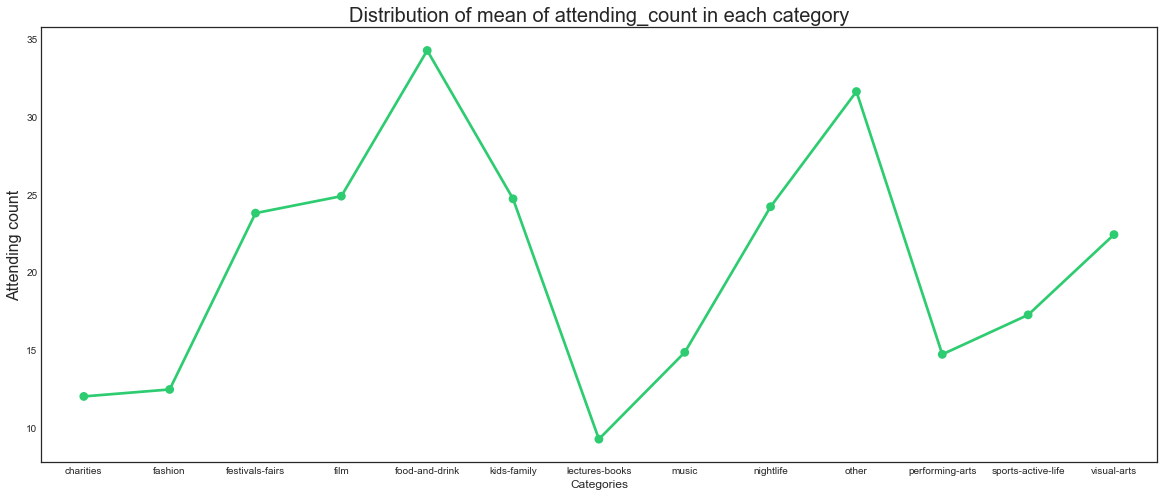

In [24]:
plt.rcParams['figure.figsize'] = 20,8
attending_count_categories_mean = df.groupby(['category']).mean()

ax = sns.pointplot(x=attending_count_categories_mean.index, 
                   y=attending_count_categories_mean['attending_count'], color="#2ecc71")
ax.set_xlabel(xlabel='Categories', fontsize=12)
ax.set_ylabel(ylabel='Attending count', fontsize=16)
ax.set_title(label='Distribution of mean of attending_count in each category', fontsize=20)
# ax.set_xticklabels( fontsize=12, rotation=50)
plt.show()

From figure above, attending_count in food-and-drink is highest. And then apart from other, kids-family has the second highest attending count. Though the category of festivals-fairs is the most held events, attending count of this category is not highest. Therefore, number of events in the category may not proportionally affect the attending count.

Then we will see the distribution of attending count in each city.

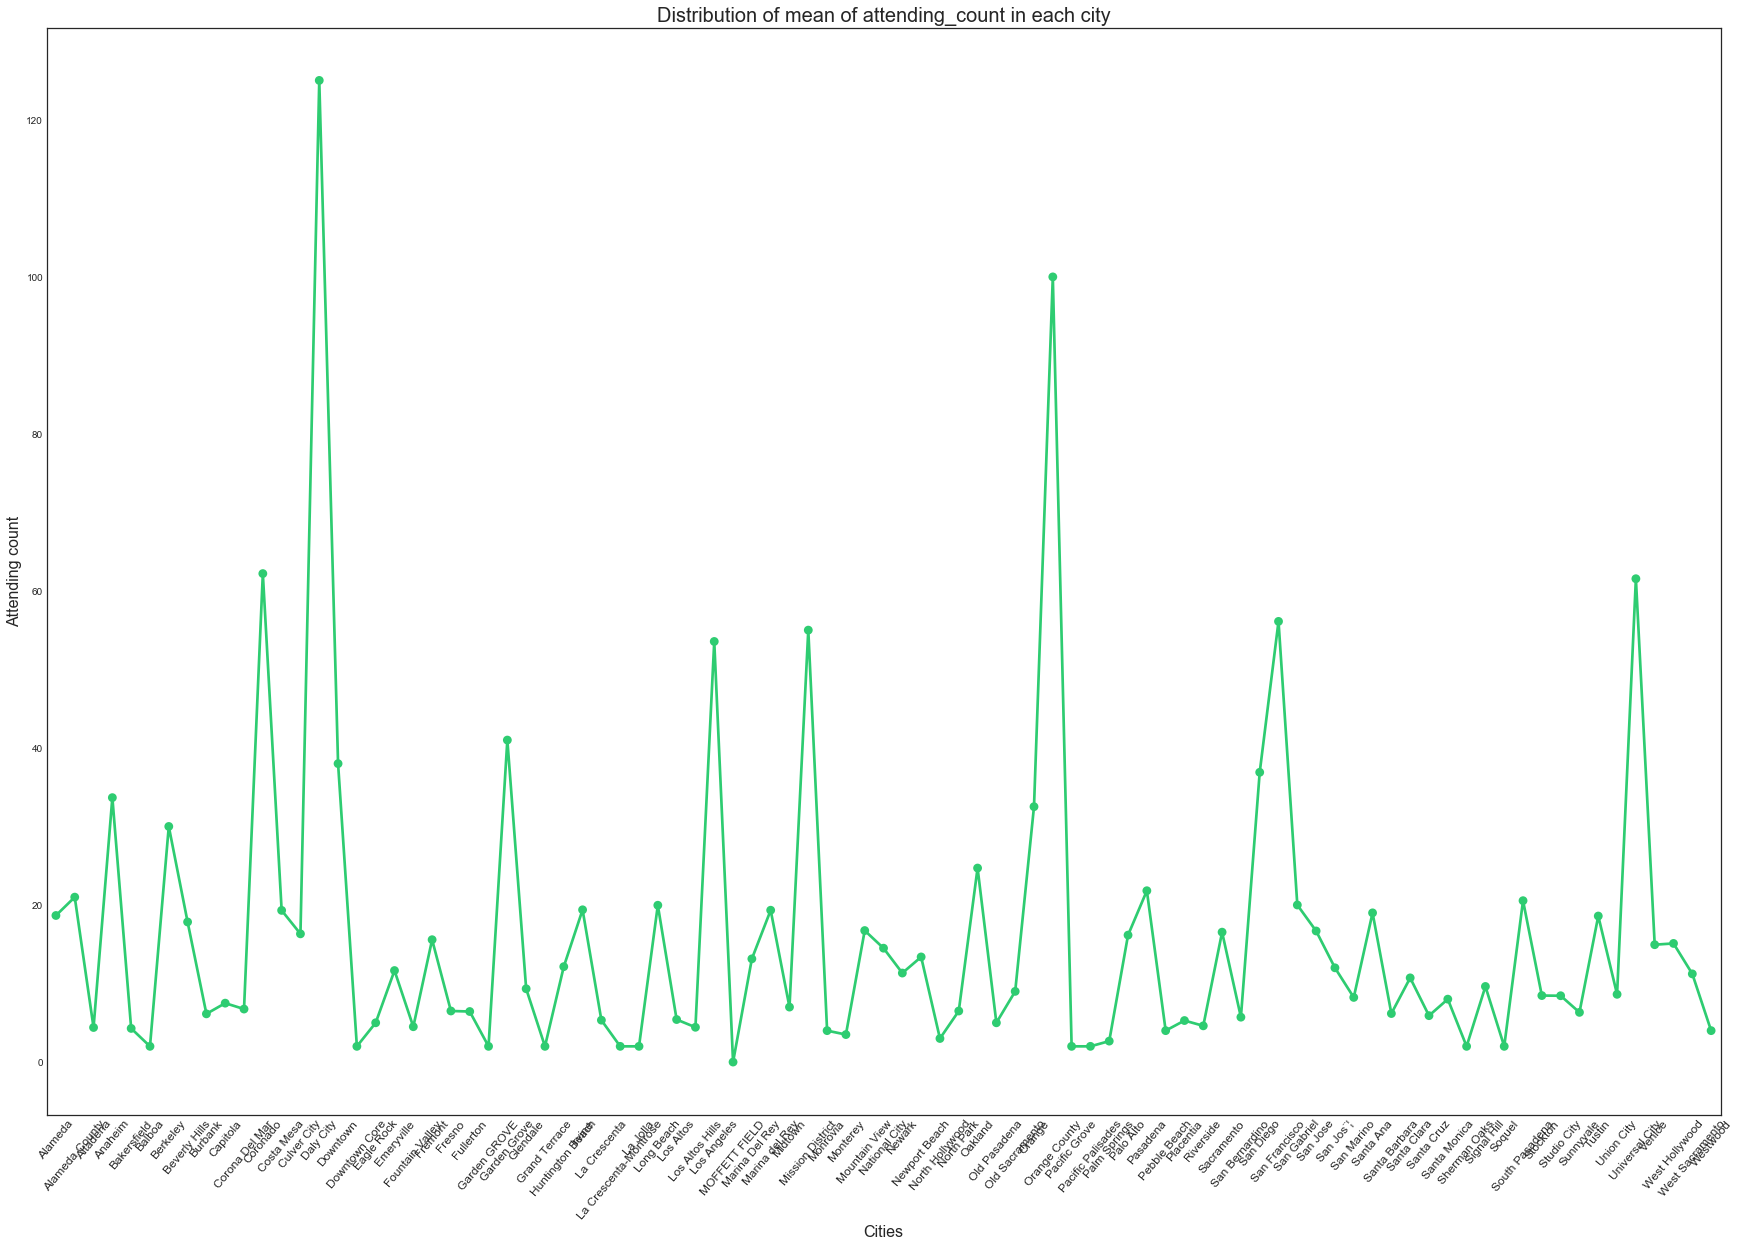

In [25]:
plt.rcParams['figure.figsize'] = 30,20
attending_count_cities_mean = df.groupby(['city']).mean()

ax = sns.pointplot(x=attending_count_cities_mean.index, 
                   y=attending_count_cities_mean['attending_count'], color="#2ecc71")
ax.set_xlabel(xlabel='Cities', fontsize=16)
ax.set_ylabel(ylabel='Attending count', fontsize=16)
ax.set_title(label='Distribution of mean of attending_count in each city', fontsize=20)
ax.set_xticklabels(labels=attending_count_cities_mean.index, fontsize=12, rotation=50)
plt.show()

Daly City has the highest mean of attending count. However, Daly City is not the top 5 city of number of events held. So, it is possible that the event here will last longer or there's an outlier in this city.

In [26]:
geo_attending_count = df[['attending_count','city', 'latitude', 'longitude']]
coordinates = []
for index, row in geo_attending_count.iterrows():
    coordinates.append([row['latitude'], row['longitude']])
geo_attending_count = geo_attending_count.assign(coords=coordinates)

In [27]:
center = geo_attending_count['coords'][10269]

Lastly, we will try to analyze distribution of attending count in each city by plotting it on the map. We used folium library to plot the heatmap on the map.

In [31]:
attending_count_map = folium.Map(location = center)
location_list = geo_attending_count['coords'].tolist()
attending_count_list = geo_attending_count['attending_count'].tolist()
attending_count_location = []
random_indices = np.random.permutation(len(geo_attending_count))

for i in random_indices[:700]:
    attending_count_location.extend([location_list[i]] * attending_count_list[i])
# print(attending_count_location)
# print()
# matr = attending_count_location.as_matrix()
attending_count_map.add_child(HeatMap(attending_count_location, radius=15))
# print(attending_count_location)

From the heatmap above, we can see top 5 cities will have more attending counts, and almost downtown of the city will have higher attending count.

In [32]:
from datetime import datetime
import scipy.sparse as sps
from collections import Counter

## Data preparation
First we will read in the data which has been cleaned from csv file and store the pandas dataframe in events variable

In [35]:
e = pd.read_csv('yelpresultCleaned.csv',encoding = "ISO-8859-1")
print(e.head())

   interested_count  is_free         city   latitude         category  \
0               193     True  Los Angeles  34.063596      kids-family   
1               191    False  Los Angeles  34.052187  festivals-fairs   
2                63     True  Los Angeles  34.052187  festivals-fairs   
3               118     True  Los Angeles  34.052187        nightlife   
4               181     True  Los Angeles  34.052187  festivals-fairs   

    longitude  is_official          time_end  \
0 -118.292773        False  2009-08-09 03:00   
1 -118.243425        False  2010-02-14 01:00   
2 -118.243425        False  2011-12-26 17:30   
3 -118.243425        False  2012-03-05 07:00   
4 -118.243425        False  2012-09-01 01:30   

                                                  id        time_start  \
0       los-angeles-korean-bbq-festival-and-cook-off  2009-08-08 19:00   
1                    los-angeles-la-street-food-fest  2010-02-13 19:00   
2       los-angeles-take-the-yelp-shops-local-pled

## Feature Engineering

In this part, we will first do the feature engineering, there are mainly three kinds of data in our dataset, numeric data, categorical data(structured data) and also text(unstructured data). For those uneric data which includes date and location information, we choose to first normalize the periodical data -- month, and then comes to the duration between the start date and end date. After we have normalized all the numeric data, we also analysed the correlation between all the processed numeric features and our response -- attending_count. From the correlation map we can see duration and interested_count has a moderate relation with response, while others all have weak correlation. Finally, we still choose to keep all those features because there are a moderate number of features we have, if we can include more features, we will have a better performance in the prediction without put too much load on the complexity of the model, secondly, because of the limitation on the amount of data's we can get from Yelp's API, some correlation between certain features and response may be not so clear, then to make our model more accurate and comprehensive at this point, we choose to include all those numeric features. Then we also considered the categorical data like the category of the event. There are totally 13 distinct event categories, so for each category, we will encode it to a vector of length 13 use one-hot-encoding. Finally, to deal with the text and append it to those features we have already had, we choose to use Bag-of-words, to first seperate the id of the event to a list of words. Then generate a word dictionary to give every unique word an index. It should be noted that, we have tried to include all the unqiue words in our dictionary, while the modelling part was very slow and there will be memory overflow problem, to solve this, we only include a certain number of most frequent unique words appears in id column. Here for each id of one event, we will encode the id to a certain number of 1-D vector, in our case, we choose 200.  
Following is the code of how we realize all the functions stated above:

#### Process categorical data
This function will take in a serialized array as the input. It will first calculate the unique members in this array, then genrate a dictionary for further look up. Then we will go through each element in the array again to get all those vectors for those categories. Finally it will return a sparse matrix.

In [36]:
def processCategorial(cate_col):
    categories = set(cate_col)
    data = np.ones(len(cate_col))
    row_ind = []
    col_ind = []
    dic = {}
    for i,c in enumerate(categories):
        dic[c] = i
    for index,c in enumerate(cate_col):
        row_ind.append(index)
        col_ind.append(dic[c])
    return sps.coo_matrix((data, (row_ind, col_ind)))

#### Process text
This function will take in a serialized array and an int number as input. The array will include all the ids in our data set. We will first build a word dictionary and then map the words in each id to word vectors. Finally it will return a sparse matrix.

In [37]:
def processText(ids,maxWords):
    unique_words = []
    dic = {}
    for i in ids:
        words = i.split('-')
        for w in words:
            unique_words.append(w)
    unique = Counter(unique_words)
    #print(unique['los'])
    unique_words = sorted(unique, key=unique.get, reverse=True)[:maxWords]
    for i,w in enumerate(unique_words):
        dic[w] = i
    data = []
    row_ind = []
    col_ind = []
    for r,i in enumerate(ids):
        indexs = [dic[w] for w in i.split('-') if w in unique_words]
        c = Counter(indexs)
        for k in sorted(c.keys()):
            data.append(c[k])
            row_ind.append(r)
            col_ind.append(k)
    return sps.coo_matrix((data, (row_ind, col_ind)),shape=(len(ids),maxWords))

#### Process numeric data
This function will take in the original data set as input and then only process those numeric columns, finally it will also return a sparse matrix including all the processed numeric features.

In [38]:
def processData(events):
    inter = []
    free = []
    official = []
    lat = []
    lon = []
    duration = []
    month = []
    #and event['attending_count']!=1
    for i,event in events.iterrows():
            inter.append(event['interested_count'])
            if event['is_free']:
                free.append(1)
            else:
                free.append(0)
            if event['is_official']:
                official.append(1)
            else:
                official.append(0)
            lat.append(event['latitude'])
            lon.append(event['longitude'])
            d1 = datetime.strptime(event['time_start'].split(' ')[0], "%Y-%m-%d")
            d2 = datetime.strptime(event['time_end'].split(' ')[0], "%Y-%m-%d")
            month.append(np.cos(d1.month/12))
            duration.append((d2 - d1).days + 1)
    columns = [inter,free,official,lat,lon,duration,month]
   
    return sps.coo_matrix(np.array(columns).T)

#### Code execution and correlation analysis

In this part we will first call the functions above to corresponding columns in original data set, then analyze the correlation between response and all the numeric features.

In [39]:
category = processCategorial(e['category'])
ids = processText(e['id'],200)
data = processData(e)

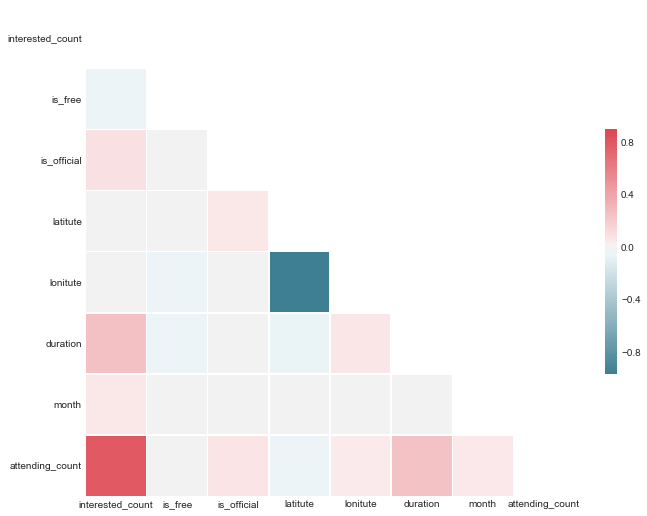

In [40]:
dt = data.todense()
d = pd.DataFrame(dt,columns = ['interested_count','is_free','is_official','latitute','lonitute','duration','month'])
ac = []
for at in e['attending_count']:
    if at != 1:
        ac.append(at)
d['attending_count'] = ac
corr = d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the correlation heatmap above, we can see that attending_count has a strong correlation with "interested_count". Besides this, "duration" and "is_official","month" also has an moderate correlation with response. "latitute" and "lontitute" and "is_free" has a weak correlation with "attending_count". #### Integration and splits of inout data
After the execution of code in corresponding clolumns of the poriginal data set, we will use a horizonal binding of the three sparse matrixs. To better test and validate our data, we would like to divide the whole data set into training data and validation data with 9:1 partition.

#### Integration and splits of inout data
After the execution of code in corresponding clolumns of the poriginal data set, we will use a horizonal binding of the three sparse matrixs. To better test and validate our data, we would like to divide the whole data set into training data and validation data with 9:1 partition.

In [41]:
inputs = sps.hstack([data,category,ids])
y = e['attending_count']
x = pd.DataFrame(inputs.todense())
part = int(len(e['attending_count'])/9)

As for the training part of the polynomial model, because the polynomial transformation will increase the data dimension exponetially, we choose to decrease the dimensions to 50 to reduce some compute complexity.

In [42]:
x_val = x[-part:]
y_val = y[-part:]
x_train = x[:-part]
y_train = y[:-part]
y_base = x[1][-part:]
x_poly = x.iloc[0:-part, 0:50]
poly_val = x.iloc[-part:, 0:50]

## Data Modeling
In this part, we have tried three models which is suitable and feasible in pur situation: linear regression model, polynomial regression model, deep learning neural network model. Besides, compared with the features we have, nearly 250 columns, the number of data points we have is relatively small, so we choose to use cross validation to get stable validation error on our training data set. 

We use scikit-learn package to implement all the three models and cross validation of them. 

### Linear Regression Model

In [43]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import cross_val_score, cross_val_predict

C:\Users\mac\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
lin_model = linear_model.LinearRegression()
linear_scores = cross_val_score(lin_model, x_train, y_train, cv=10)
print ('Cross-validated scores for linear regression model:',linear_scores)
print ('Mean Cross-validated scores for linear regression model:', np.mean(linear_scores))

Cross-validated scores for linear regression model: [ 5.34944405e-01  7.06639212e-01 -2.41830082e-01  6.02200705e-01
  6.80540927e-01 -9.16806512e+11 -1.20815177e+00  7.90891001e-01
  5.15806179e-01 -2.23974234e+13]
Mean Cross-validated scores for linear regression model: -2331422993183.757


From the cross validation score(r-score) of the regression model, we can see that there is a large variance on different split on training data set. It can be concluded that there is a large variance on our training data features and response. 

### Polynimial Regression Model

In [45]:
from sklearn.preprocessing import PolynomialFeatures

In [46]:
poly2 = PolynomialFeatures(degree=2)
X_2 = poly2.fit_transform(x_poly)
X_val = poly2.fit_transform(poly_val)
poly2_model = linear_model.LinearRegression()
poly2_scores = cross_val_score(poly2_model, X_2, y_train, cv=10)
print ('Cross-validated scores for degree 2 polynomial model:',poly2_scores)
print ('Mean Cross-validated scores for degree 2 polynomial model:', np.mean(poly2_scores))

Cross-validated scores for degree 2 polynomial model: [-1.33550862e+04 -1.62817356e+02 -6.13446666e+11 -7.75088859e+14
 -2.47269631e+06  6.78888015e-01 -9.26531891e+10 -1.64492980e+06
 -1.29543229e+02 -3.73901850e+02]
Mean Cross-validated scores for degree 2 polynomial model: -77579496258943.39


From this cross validation r score and mean of them, we can see polynomial model has a very high variance on those scores, meaning poor in generalization, and at the same time did not do well in predicting the response even in one folder.

### Neural Network Model

In [47]:
from sklearn.neural_network import MLPRegressor

In [48]:
nn = MLPRegressor()
nn_scores = cross_val_score(nn, x_train, y_train, cv=10)
print ('Cross-validated scores for simple neural network model:',nn_scores)
print ('Mean Cross-validated scores for simple neural network model:', np.mean(nn_scores))

Cross-validated scores for simple neural network model: [0.57158035 0.76341765 0.0388401  0.71895933 0.7315799  0.785882
 0.24537286 0.84076107 0.62683786 0.43923344]
Mean Cross-validated scores for simple neural network model: 0.5762464553350741


From the matrics above we can see neural network model has an average r score of 0.58, it is acceptable in our case and also has a relatively stable cross validation errors. 

### Model Evaluation and Comparison
In this part we will compare all the three models performance on the training set, to do the visualization on the predicted value and actual value. 

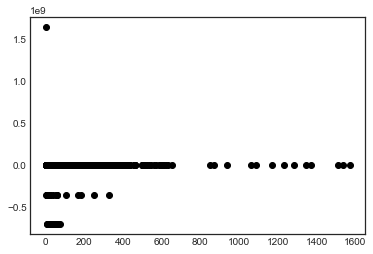

In [49]:
lin_pred = cross_val_predict(lin_model, x_train, y_train, cv=10)
plt.scatter(y_train,lin_pred,color='black')

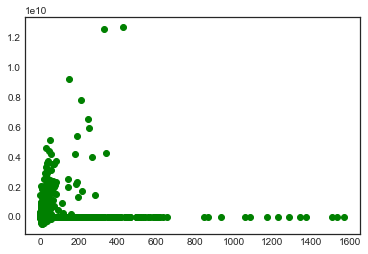

In [50]:
poly_pred = cross_val_predict(poly2_model, X_2, y_train, cv=10)
plt.scatter(y_train,poly_pred,color='green')

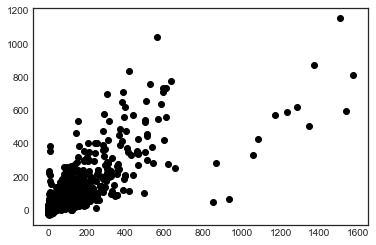

In [51]:
nn_pred = cross_val_predict(nn, x_train, y_train, cv=10)
plt.scatter(y_train,nn_pred,color='black')

In [52]:
print(mean_squared_error(y_train, lin_pred))
print(mean_squared_error(y_train, poly_pred))
print(mean_squared_error(y_train, nn_pred))

2018827103944733.2
1.3590235938693894e+17
1745.6196711348275


From the data visulaization and MSE value above, we can see clearly that neural network has better performance over the other two regression models. Next we still compared the three models on the validation data set. First we fit every model with training data set without cross validation. Then we calculated the MSE of each model on the unseen data(validation set)

In [53]:
lin_model.fit(x_train,y_train)
lin_pred1 = lin_model.predict(x_val)
lin_true = [1 if x < 0 else x for x in lin_pred1]
poly2_model.fit(X_2,y_train)
poly_pred1 = poly2_model.predict(X_val)
poly_true = [1 if x < 0 else x for x in poly_pred1]
nn.fit(x_train,y_train)
nn_pred1 = nn.predict(x_val)
nn_true = [1 if x < 0 else x for x in nn_pred1]
print("Linear regression model: " + str(mean_squared_error(y_val, lin_true)))
print("Polinomial regression model: " + str(mean_squared_error(y_val, poly_true)))
print("Neural Network model: " + str(mean_squared_error(y_val, nn_true)))

Linear regression model: 2.0934780277674327e+23
Polinomial regression model: 24103575930.186394
Neural Network model: 62.84336212433797


In [54]:
print(mean_squared_error(y_val, y_base))

70.97863682604273


From the above statistics, we can see neural network again has better performance than other models on validation set. Besides, conpared to the baseline, interested_count, neural network also has better performance and less mean squared error on onseen data.  

## Conclusion
 Regarding all the process across pur project we can conclude that:
 
 (1) Our model has better performance than the baseline model. Among all the models we have tried, although only the neural network has a decent r-score, our model performance is better than just predict the attending count use interested count. 
 
 (2) From the comparison between the three models, it is obvious that polynomial model has a bad performance regarding our high dimensional data, it may because the weak relationship between some features to our response and the complexity of the polynomial model. Regression model has an unstable performance, the folder r-score during the cross validation varies a lot in linear regression. Finally neural network model is which we choosed and recommendded not only on the gernalization of this model based on the performance on all the folders, but also the smaller RMSE when predicting on the test set.

## Lessons Learned
During the project, we have tried many approches which we learned from class and then apply them in the practical situation in an suitable way like data encoding and data modeling. From this process, we have conclude some tips on doing the data science projects:
(1) Before choosing or design models and do feature engineering, it is very important to take a deep look into the original data to remove some outliers to avoid some misleading information on the following data modeling process. Because in the very begining, we get a very high RMSE even on the neural network model, fianlly we were aware that it is becuase there are some noise data existed on the attending_count column, many data has a attending_count of 1 even the iterested_count is thousands. So beside clean the None data point, distribution on response and every feature are also very important indication on how we should process the data and choose the suitable candidate models.
(2) When there is s shortage in labeled data we have, it is often a good choice to use cross validation to get an unbiased validation error of each model. Especially when there is a large variance among the priginal data points. 